## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [207]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [208]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [209]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

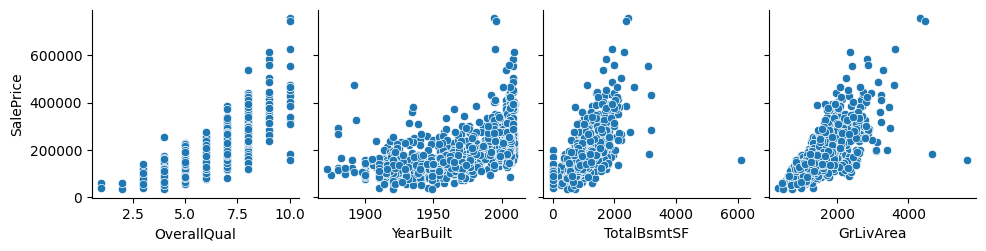

In [210]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [211]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [212]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [213]:
type(y_test)

pandas.core.series.Series

In [214]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [215]:
type(y_val)

pandas.core.series.Series

In [216]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [217]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(4, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [218]:
# Construct a model with one layer
class RegressionModel(nn.Module):
    
    def __init__(self, activation, hidden_size):
        super().__init__()
        
        self.layer1 = nn.Linear(4, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.activation = activation
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        return x

In [219]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [220]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    train_error = []
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre = model(X)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

#         print('Epoch [{}/{}], Loss_error: {:.4f}'.format(epoch+1, num_epochs,  epoch_average_loss))
        train_error.append(epoch_average_loss)
    return sum(train_error)/len(train_error)       

In [222]:
param_grid = {
    'activation': [torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid()],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [10, 100, 200, 400],
    'optimizer': [optim.Adam, optim.RMSprop],
    'loss': [nn.MSELoss()]
}

epochs = 10
min_loss = np.inf
best_params = None

for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer_class in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for loss in param_grid['loss']:
                        # Create the model: 
                        model = RegressionModel(activation, 128)
                        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
                        train_loss = train(epochs, batch_size, loss, optimizer, model, train_set)
                        train_loss = float("{:.2f}".format(train_loss))
                        
                        print("Hyper Parameters: activation-function: {}, learning-rate: {}, optmizer: {}, batch-size: {}, loss-function: {}".
                              format(activation, learning_rate, str(optimizer_class), batch_size, loss))
                        print("Loss Score: {}".format(train_loss))
                        print("=========================================\n")
                        
                        # Update the best hyperparameters and accuracy
                        if train_loss < min_loss:
                            min_loss = train_loss
                            best_params = {'activation': activation, 'learning_rate': learning_rate,
                                           'optimizer': optimizer_class,
                                          'batch_size': batch_size, 'loss': loss}

print("Best Hyper parameters for Classification Model")
print(best_params)

print("\nMinimum Loss on best parameters")
print(min_loss)

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Loss Score: 6715125277.07

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 100, loss-function: MSELoss()
Loss Score: 37411336089.6

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 200, loss-function: MSELoss()
Loss Score: 39498616995.84

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 400, loss-function: MSELoss()
Loss Score: 47496703836.16

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.optim.rmsprop.RMSprop'>, batch-size: 10, loss-function: MSELoss()
Loss Score: 3233727343.9

Hyper Parameters: activation-function: ReLU(), learning-rate: 0.01, optmizer: <class 'torch.opt

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.001, optmizer: <class 'torch.optim.rmsprop.RMSprop'>, batch-size: 100, loss-function: MSELoss()
Loss Score: 39663169863.68

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.001, optmizer: <class 'torch.optim.rmsprop.RMSprop'>, batch-size: 200, loss-function: MSELoss()
Loss Score: 39664466247.68

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.001, optmizer: <class 'torch.optim.rmsprop.RMSprop'>, batch-size: 400, loss-function: MSELoss()
Loss Score: 47614268211.2

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Loss Score: 39665563639.81

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 100, loss-function: MSELoss()
Loss Score: 39667626291.2

Hyper Parameters: activation-function: Tanh(), learning-rate: 0.0001, opt

In [230]:
min_loss = np.inf
_params = best_params
epochs_list = [20, 50, 100, 200, 500]


for epochs in epochs_list:
    # Create the model: 
    model = RegressionModel(_params['activation'], 128)
    optimizer = optimizer_class(model.parameters(), lr=_params['learning_rate'])
    train_loss = train(epochs, _params['batch_size'], _params['loss'], optimizer, model, train_set)
    train_losstrain_loss = float("{:.2f}".format(train_loss))

    if train_loss < min_loss:
        min_loss = train_loss
        _params['epochs'] = epochs
                                 
print("***** Best Hyper parameters for Regression Model *****\n")
print(_params)

print("\n\n***** Minimum Loss on tunned Parameters *****\n")
print(min_loss)

***** Best Hyper parameters for Regression Model *****

{'activation': ReLU(), 'learning_rate': 0.01, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'batch_size': 10, 'loss': MSELoss(), 'epochs': 500}


***** Minimum Loss on tunned Parameters *****

1165575763.6164804


### Evaluate the Model on the validation set

In [238]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(X_val)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 966334080.0


### Evaluate the Model on the test set

In [235]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(X_test)
error = criterion(y_pre_val, torch.tensor(np.array(y_test)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 2325866752.0


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.